Connected to ml_env (Python 3.10.16)

In [ ]:
import pandas as pd

df = pd.read_csv("canser.csv")

In [ ]:
df.head(3)

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84


In [ ]:
df.describe()
df.isnull().sum()

Patient_ID               0
Age                      0
Gender                   0
Country_Region           0
Year                     0
Genetic_Risk             0
Air_Pollution            0
Alcohol_Use              0
Smoking                  0
Obesity_Level            0
Cancer_Type              0
Cancer_Stage             0
Treatment_Cost_USD       0
Survival_Years           0
Target_Severity_Score    0
dtype: int64

In [ ]:
df.dtypes

Patient_ID                object
Age                        int64
Gender                    object
Country_Region            object
Year                       int64
Genetic_Risk             float64
Air_Pollution            float64
Alcohol_Use              float64
Smoking                  float64
Obesity_Level            float64
Cancer_Type               object
Cancer_Stage              object
Treatment_Cost_USD       float64
Survival_Years           float64
Target_Severity_Score    float64
dtype: object

In [ ]:
df["Country_Region"].unique()

array(['UK', 'China', 'Pakistan', 'Brazil', 'Germany', 'Canada', 'USA',
       'India', 'Australia', 'Russia'], dtype=object)

In [ ]:
df["Country_Region"].value_counts()
df["Cancer_Stage"].value_counts()

Cancer_Stage
Stage II     10124
Stage I      10046
Stage III    10008
Stage IV      9933
Stage 0       9889
Name: count, dtype: int64

In [ ]:
df = pd.get_dummies(df, columns=["Cancer_Type", "Country_Region", "Gender", "Cancer_Stage"], drop_first=True)

In [ ]:
df = df.drop(columns = ["Patient_ID", "Year"])

In [ ]:
df.head(3)

,Age,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Treatment_Cost_USD,Survival_Years,Target_Severity_Score,Cancer_Type_Cervical,...,Country_Region_Pakistan,Country_Region_Russia,Country_Region_UK,Country_Region_USA,Gender_Male,Gender_Other,Cancer_Stage_Stage I,Cancer_Stage_Stage II,Cancer_Stage_Stage III,Cancer_Stage_Stage IV
0,71,6.4,2.8,9.5,0.9,8.7,62913.44,5.9,4.92,False,...,False,False,True,False,True,False,False,False,True,False
1,34,1.3,4.5,3.7,3.9,6.3,12573.41,4.7,4.65,False,...,False,False,False,False,True,False,False,False,False,False
2,80,7.4,7.9,2.4,4.7,0.1,6984.33,7.1,5.84,False,...,True,False,False,False,True,False,False,True,False,False


In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_columns = df.select_dtypes(include=["float64", "int64"])
scalers = {}
for col in num_columns:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [ ]:
X = df.drop("Target_Severity_Score", axis=1)
y = df["Target_Severity_Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test  = y_test.astype('float32')

class CancerDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = CancerDataset(X_train, y_train)
test_dataset = CancerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
class CancerMLP(nn.Module):
    def __init__(self, input_size):
        super(CancerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [ ]:
model = CancerMLP(input_size=df.shape[1]-1).to("cuda")
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def train_model(model, dataloader, criterion, optimizer):
    running_loss = 0.0
    total = 0
    model.train()
    for x_batch, y_batch in tqdm(dataloader, desc="Train model: "):
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y_batch.size(0)
        total += y_batch.size(0)
    return running_loss / total

def evaulate(model, dataloader, criterion):
    running_loss = 0.0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc="Eval: "):
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * y_batch.size(0)
            total += y_batch.size(0)
    return running_loss / total

def test_model(model, dataloader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm(dataloader):
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)
            all_preds.extend(outputs.squeeze(1).cpu().numpy())
            all_targets.extend(y_batch.squeeze(1).cpu().numpy())
    return all_preds, all_targets

epochs = 50
train_losses, test_losses = [], []
for epoch in range(epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    test_loss = evaulate(model, test_loader, criterion)
    scheduler.step(test_loss)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"  Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {test_loss:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
all_preds, all_labels = test_model(model, test_loader)
mae = mean_absolute_error(all_labels, all_preds)
rmse = root_mean_squared_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

Eval: 100%|██████████| 40/40 [00:00<00:00, 614.67it/s]


  Epoch 1/50
  Train Loss: 0.0276
  Val   Loss: 0.0177
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 797.08it/s]


  Epoch 2/50
  Train Loss: 0.0150
  Val   Loss: 0.0107
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 937.29it/s]


  Epoch 3/50
  Train Loss: 0.0060
  Val   Loss: 0.0020
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 1021.88it/s]


  Epoch 4/50
  Train Loss: 0.0010
  Val   Loss: 0.0006
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 925.37it/s]


  Epoch 5/50
  Train Loss: 0.0005
  Val   Loss: 0.0004
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 1021.65it/s]


  Epoch 6/50
  Train Loss: 0.0004
  Val   Loss: 0.0003
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 999.57it/s]


  Epoch 7/50
  Train Loss: 0.0003
  Val   Loss: 0.0003
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 874.35it/s]


  Epoch 8/50
  Train Loss: 0.0003
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 842.37it/s]


  Epoch 9/50
  Train Loss: 0.0002
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 674.37it/s]


  Epoch 10/50
  Train Loss: 0.0002
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 500.30it/s]


  Epoch 11/50
  Train Loss: 0.0002
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 500.60it/s]


  Epoch 12/50
  Train Loss: 0.0002
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 429.37it/s]


  Epoch 13/50
  Train Loss: 0.0002
  Val   Loss: 0.0002
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 393.55it/s]


  Epoch 14/50
  Train Loss: 0.0002
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 400.87it/s]


  Epoch 15/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 420.76it/s]


  Epoch 16/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 550.62it/s]


  Epoch 17/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 499.00it/s]


  Epoch 18/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 509.95it/s]


  Epoch 19/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 436.23it/s]


  Epoch 20/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 450.57it/s]


  Epoch 21/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 436.02it/s]


  Epoch 22/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 527.87it/s]


  Epoch 23/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 449.89it/s]


  Epoch 24/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 361.22it/s]


  Epoch 25/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 460.16it/s]


  Epoch 26/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 380.75it/s]


  Epoch 27/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 501.70it/s]


  Epoch 28/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 426.83it/s]


  Epoch 29/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 524.82it/s]


  Epoch 30/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 535.07it/s]


  Epoch 31/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 502.51it/s]


  Epoch 32/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 420.79it/s]


  Epoch 33/50
  Train Loss: 0.0001
  Val   Loss: 0.0001
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 497.49it/s]


  Epoch 34/50
  Train Loss: 0.0001
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 525.16it/s]


  Epoch 35/50
  Train Loss: 0.0001
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 501.74it/s]


  Epoch 36/50
  Train Loss: 0.0001
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 516.75it/s]


  Epoch 37/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 526.35it/s]


  Epoch 38/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 583.41it/s]


  Epoch 39/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 676.03it/s]


  Epoch 40/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 724.65it/s]


  Epoch 41/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 697.13it/s]


  Epoch 42/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 534.43it/s]


  Epoch 43/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 502.97it/s]


  Epoch 44/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 526.13it/s]


  Epoch 45/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 410.86it/s]


  Epoch 46/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 460.91it/s]


  Epoch 47/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 533.65it/s]


  Epoch 48/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 439.82it/s]


  Epoch 49/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


Eval: 100%|██████████| 40/40 [00:00<00:00, 368.10it/s]


  Epoch 50/50
  Train Loss: 0.0000
  Val   Loss: 0.0000
  LR: 0.010000


100%|██████████| 40/40 [00:00<00:00, 364.13it/s]


MLP Sonuçları:
MAE:  0.0040
RMSE: 0.0054
R²:   0.9986


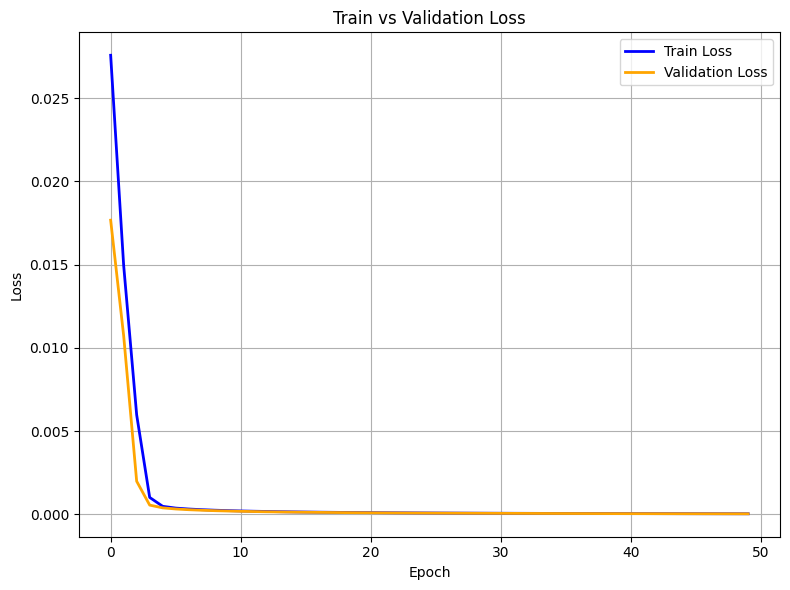

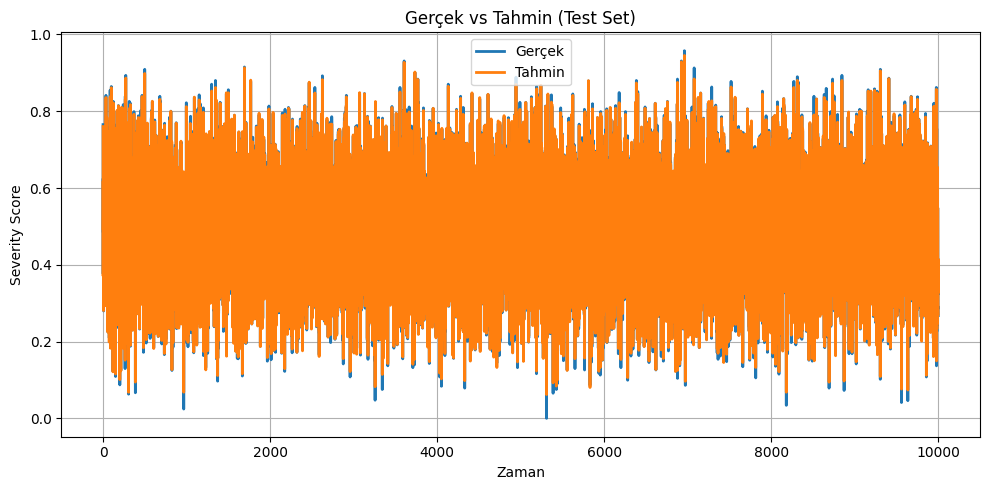

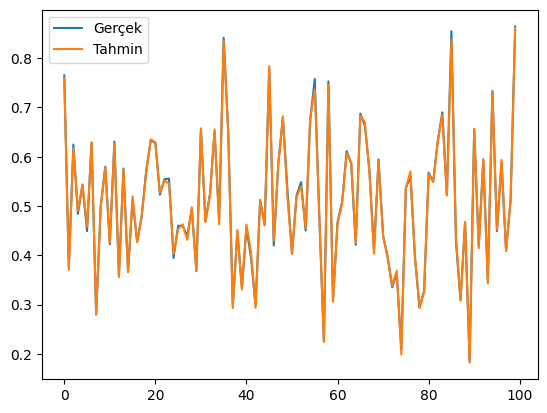

In [ ]:
import matplotlib.pyplot as plt

print("MLP Sonuçları:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
plt.plot(test_losses, label="Validation Loss", color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(all_labels, label="Gerçek", linewidth=2)
plt.plot(all_preds, label="Tahmin", linewidth=2)
plt.xlabel("Zaman")
plt.ylabel("Severity Score")
plt.title("Gerçek vs Tahmin (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
plt.plot(all_labels[:100], label="Gerçek")
plt.plot(all_preds[:100], label="Tahmin")
plt.legend()
plt.show()

XGBoost Sonuçları:
MAE:  0.0117
RMSE: 0.0148
R²:   0.9894


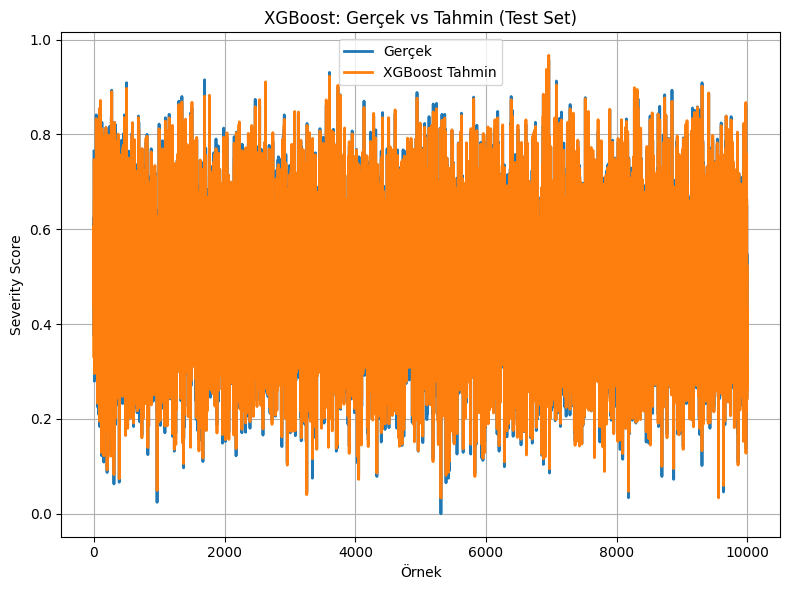

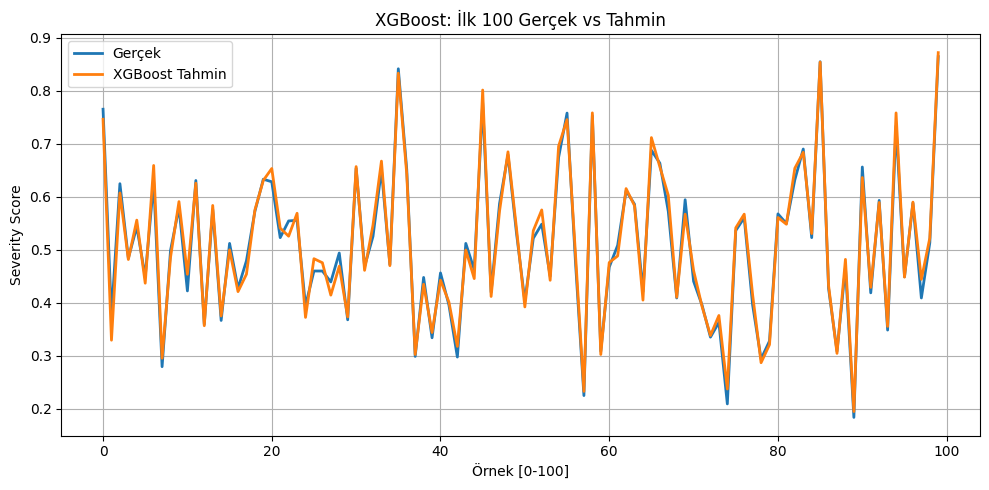

In [ ]:
# XGBoost test tahmini ve metrikler
y_pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Sonuçları:")
print(f"MAE:  {mae_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²:   {r2_xgb:.4f}")

plt.figure(figsize=(8,6))
plt.plot(y_test.values, label="Gerçek", linewidth=2)
plt.plot(y_pred_xgb, label="XGBoost Tahmin", linewidth=2)
plt.xlabel("Örnek")
plt.ylabel("Severity Score")
plt.title("XGBoost: Gerçek vs Tahmin (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label="Gerçek", linewidth=2)
plt.plot(y_pred_xgb[:100], label="XGBoost Tahmin", linewidth=2)
plt.xlabel("Örnek [0-100]")
plt.ylabel("Severity Score")
plt.title("XGBoost: İlk 100 Gerçek vs Tahmin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()